<div class="alert alert-block alert-info">
<h2>Index</h2>
<ol>
    <li><a href="#ref1">Libraries</a></li>
    <li><a href="#ref2">Data</a></li>
    <li><a href="#ref3">Clean & Lemmatization</a></li>
    <li><a href="#ref4">Analysis</a></li>
    <li><a href="#ref5">Clusters topics</a></li>
  </ol>    
</div>

<a id="ref1"></a>
<h2>Libraries</h2>

In [58]:
# Standard Libraries
import os
import re
import json
import time
import string
import warnings
from dotenv import load_dotenv
import os
from openai import OpenAI
import pandas as pd

# Third-Party Libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output

# Scientific and Computational Libraries
from scipy.spatial import ConvexHull
from scipy import interpolate

# NLP Libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Text Processing Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Machine Learning Libraries
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Dimensionality Reduction and Clustering Libraries
import umap
import hdbscan

# Custom/Other Libraries
from pointgrid import align_points_to_grid

<a id="ref2"></a>
<h2>Data</h2>

In [59]:
query = "Query_AI-magazines-mediacloud-2021-24"
magazine = "technologyreview.com"

# Load data
FEATHER_FILE = query + ".feather"
df = pd.read_feather("data/" + FEATHER_FILE)

# Filter by magazine
df = df[df["media_name"] == magazine]

# Clean
df = df[df['text_downloaded'] != False]
df = df.drop(['id', 'indexed_date', 'media_name', 'media_url', 'language', 'text_downloaded'], axis=1)

# Reset index
df = df.reset_index(drop=True)

print(
    f"The length of the dataset is {df.shape[0]}\n"
    f"Records range from {df['year'].min()} to {df['year'].max()}"
)

df.sample(1)

The length of the dataset is 590
Records range from 2021 to 2024


,publish_date,title,url,year,text,GPE,IND,ORG
573,2021-04-23,Stop talking about AI ethics. It’s time to tal...,https://www.technologyreview.com/2021/04/23/10...,2021,Stop talking about AI ethics. It’s time to tal...,"[Nevada, Clayton Valley, Philadelphia, Los Ang...","[Kate Crawford, Hans, Clever Hans, Hans, Kate ...","[AI, AI, AI, AI, Crawford, Crawford, Amazon, C..."


## Word Count

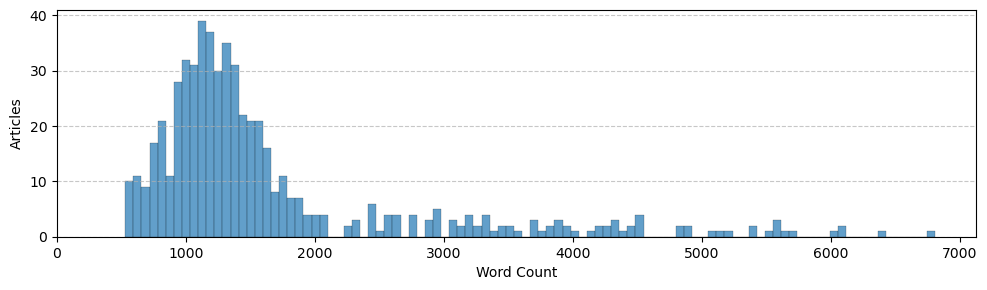

In [60]:
# Calculate and filter word count
df["word_count"] = df["text"].str.split().str.len()
df = df[df["word_count"].between(500, 8000)]

# Plot histogram
plt.figure(figsize=(10, 3))
plt.hist(df["word_count"], bins=100, edgecolor="black", alpha=0.7, linewidth=0.2)
plt.xlabel("Word Count")
plt.ylabel("Articles")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set x-axis ticks at every 200 units
plt.xticks(range(0, df["word_count"].max() + 1000, 1000))

plt.tight_layout()
plt.show()

## Parsing

In [61]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm") # Small Model
# nlp = spacy.load("en_core_web_trf") # Large Model

# Enable tqdm for pandas
tqdm.pandas()

# Parse text column with a progress bar
start_time = time.time()
df['parsing'] = df['text'].progress_apply(nlp)
elapsed_time = time.time() - start_time

print(f"Processing completed in {elapsed_time:.2f} seconds.")

100%|██████████| 567/567 [02:11<00:00,  4.30it/s]

Processing completed in 131.96 seconds.


## Tokenization

In [ ]:
# Define custom stop words
CUSTOM_STOP_WORDS = {
    # 'ai', 'say', 'year', 'way', 'use', 'need', 'technology', 
    # 'tech', 'mit', 'review', 'datum', 'thing', 'model', 'company', 'people', 'problem'
}

# Returns lemmatized tokens in lowercase
def clean_tokens(doc):
    return [
        token.lemma_.lower().strip()
        for token in doc
        if token.pos_ in {"PROPN", "NOUN"} # Filter by type
        and token.is_alpha # Exclude non-alphabetical lemmas
        and token.lemma_.lower() not in STOP_WORDS
        and token.lemma_.lower() not in CUSTOM_STOP_WORDS
    ]

# Apply the cleaning function to store lemmas as lists
df['lemmas'] = df['parsing'].apply(clean_tokens)

# Display the first few rows to verify results
print(df[['parsing', 'lemmas']].sample(1))

                                               parsing  \
333  (The, Download, :, America, ’s, AI, lawsuits, ...   

                                                lemmas  
333  [download, america, ai, lawsuit, threads, rest...  


## Frequency

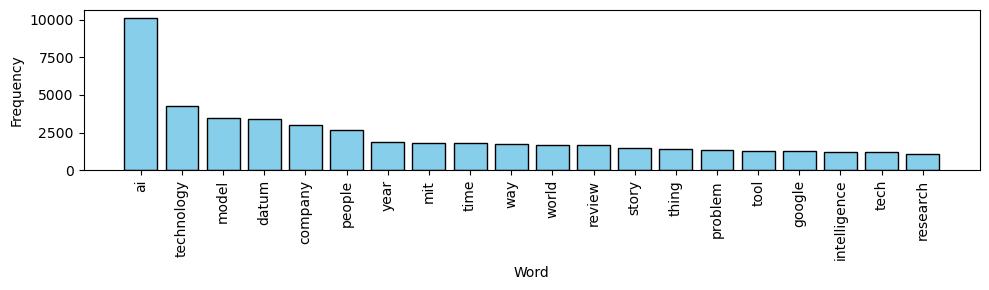

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

# Function to get top N words and their counts
def get_top_n_words(text_data, n_top_words, stop_words='english'):
    count_vectorizer = CountVectorizer(stop_words=stop_words)
    word_matrix = count_vectorizer.fit_transform([' '.join(words) for words in text_data])
    word_counts = np.asarray(word_matrix.sum(axis=0)).flatten()
    top_indices = word_counts.argsort()[::-1][:n_top_words]
    top_words = np.array(count_vectorizer.get_feature_names_out())[top_indices]
    top_counts = word_counts[top_indices]
    return top_words, top_counts

# Get top words and their counts
top_words, top_counts = get_top_n_words(df['lemmas'], n_top_words=20)

# Plot the results
plt.figure(figsize=(10, 3))
plt.bar(top_words, top_counts, color='skyblue', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Temperature

In [64]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(1)

,publish_date,title,url,year,text,GPE,IND,ORG,word_count,parsing,lemmas,temperature,color
447,2022-11-22,China just announced a new social credit law. ...,https://www.technologyreview.com/2022/11/22/10...,2022,China just announced a new social credit law. ...,"[China, China, China, China, China, China, Chi...","[Jeremy Daum, Paul Tsai, Daum, Kendra Schaefer...","[Tech Review, a Black Mirror, the Social Credi...",2911,"(China, just, announced, a, new, social, credi...","[china, credit, law, west, china, credit, syst...",0,#aa0055


## TF-IDF

In [65]:
# Convert lemmas column into a temporary array of strings
lemmas_as_strings = df["lemmas"].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).to_numpy()

# Initialize CountVectorizer
vectorizer = CountVectorizer(lowercase=False)

# Vectorize the lemmas array
X = vectorizer.fit_transform(lemmas_as_strings)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
train_data = tfidf.fit_transform(X)

# Display results
print(f"Vocabulary: {vectorizer.get_feature_names_out()[:10]}")  # First 10 terms
print(f"Shape of the document-term matrix: {X.shape}")
print(f"Shape of the TF-IDF matrix: {train_data.shape}")

Vocabulary: ['aaa' 'aae' 'aaron' 'abake' 'abba' 'abbate' 'abbeel' 'abbott'
 'abbreviation' 'abby']
Shape of the document-term matrix: (567, 14574)
Shape of the TF-IDF matrix: (567, 14574)


## UMAP

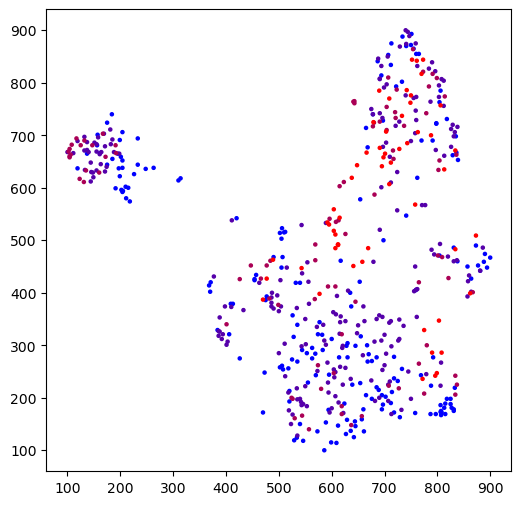

In [66]:
# Suppress the specific UserWarning from UMAP about n_jobs and random_state
warnings.filterwarnings(
    action='ignore',
    message='n_jobs value.*',
    category=UserWarning,
    module='umap'
)

# Define UMAP parameters
umap_params = {
    'random_state': 1,
    'n_components': 2,
    'n_neighbors': 15,  # Adjusted for typical usage
    'min_dist': 0.1,
    'metric': 'hellinger'
}

# Compute UMAP embedding
reducer = umap.UMAP(**umap_params)
embedding = reducer.fit_transform(train_data)

# Scale embeddings
scaler = MinMaxScaler(feature_range=(100, 900))
embedding_scaled = scaler.fit_transform(embedding).astype(int)

# Assign embeddings to 'x' and 'y' in the DataFrame
df["x"], df["y"] = embedding_scaled[:, 0], embedding_scaled[:, 1]

# Adjust the figure size to make the plot smaller
plt.figure(figsize=(6, 6), dpi=100)  # Reduced width and height
plt.scatter(df["x"], df["y"], s=5, c=df["color"])

## Clustering

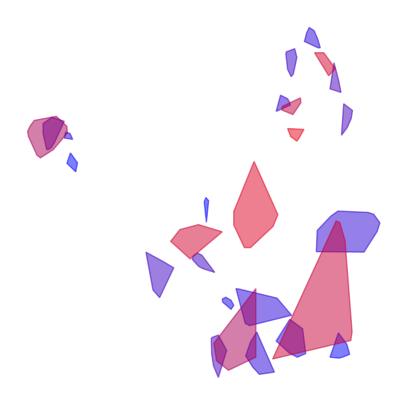

In [67]:
df["cluster"] = "-1"  # Initialize 'cluster' column

hdbscan_params = {
    "min_cluster_size": 5,
    "min_samples": 5,
    "cluster_selection_epsilon": 0.1,
    # 'metric': 'haversine'
    'cluster_selection_method': 'leaf',
}

# Define conditions and prefixes
conditions = [(df["temperature"] > 0, "p_"), (df["temperature"] <= 0, "n_")]

# Perform clustering and assign labels
for condition, prefix in conditions:
    indices = df.index[condition]
    embedding = df.loc[indices, ["x", "y"]].to_numpy()

    # Initialize and fit the HDBSCAN clusterer with parameters
    clusterer = hdbscan.HDBSCAN(**hdbscan_params)
    labels = clusterer.fit_predict(embedding)

    # Apply prefix to cluster labels
    df.loc[indices, "cluster"] = [
        f"{prefix}{label}" if label != -1 else str(label) for label in labels
    ]

##
## Visualization
##



plt.figure(figsize=(5, 5))
plt.axis("off")

# Get unique cluster labels
clusters = [cluster for cluster in df["cluster"].unique() if cluster != "-1"]

# print(clusters)

for cluster in clusters:
    # Get data for the current cluster
    cluster_data = df[df["cluster"] == cluster]
    cluster_points = cluster_data[["x", "y"]].values
    cluster_colors = cluster_data["color"].values  # Array of colors

    # Need at least 3 points to compute a convex hull
    # if len(cluster_points) < 3:
    #     print(f"Cluster '{cluster}' has less than 3 points ({len(cluster_points)}). Skipping.")
    #     continue

    # Compute the convex hull
    hull = ConvexHull(cluster_points)
    hull_vertices = cluster_points[hull.vertices]

    # Close the hull by appending the first point at the end
    x_hull = np.append(hull_vertices[:, 0], hull_vertices[0, 0])
    y_hull = np.append(hull_vertices[:, 1], hull_vertices[0, 1])

    # Convert colors to RGB format
    rgb_colors = []
    for color in cluster_colors:
        try:
            rgb = mcolors.to_rgb(color)
            rgb_colors.append(rgb)
        except ValueError:
            print(f"Invalid color '{color}' in cluster '{cluster}'. Using default color.")
            rgb_colors.append((0, 0, 0))  # Default to black if color is invalid

    # Compute average RGB values
    avg_rgb = np.mean(rgb_colors, axis=0)

    # Ensure RGB values are within [0, 1]
    avg_rgb = np.clip(avg_rgb, 0, 1)

    # Convert average RGB back to hex color
    avg_color_hex = mcolors.to_hex(avg_rgb)

    # Plot the convex hull with the average color
    plt.fill(x_hull, y_hull, color=avg_color_hex, alpha=0.5)

plt.show()


In [ ]:
# Remove the top 10/20 keywords for the entire corpus for each article

# 1. Put together all the lemmas
# 2. Identify the 10/20/30 most common ones
# 3. Remove for every article the l;ist of the most common lemmas


# Extract keywords for each cluster
def extract_keywords(df, top_n=15, max_features=1000):
    results = []

    for cluster_id, group in df.groupby("cluster"):
        # Vectorize the text
        vectorizer = CountVectorizer(max_features=max_features)
        lemmas = group["lemmas"] = group["lemmas"].apply(
            lambda x: " ".join(x) if isinstance(x, list) else str(x)
        )
        # print(group["lemmas"])
        # print(test)
        # print(" ".join(group['lemmas']))
        X = vectorizer.fit_transform(lemmas)

        # Calculate word frequencies
        word_sums = X.sum(axis=0).A1  # Convert matrix to array
        words_freq = sorted(
            ((word, word_sums[idx]) for word, idx in vectorizer.vocabulary_.items()),
            key=lambda x: x[1], reverse=True
        )

        # Get top keywords
        top_keywords = [word for word, _ in words_freq[:top_n]]

        # Append cluster results
        results.append({'cluster': cluster_id, 'top_keywords': top_keywords})

    return pd.DataFrame(results)


# Usage
keywords_df = extract_keywords(df)

keywords_df

,cluster,top_keywords
0,-1,"[ai, technology, model, company, datum, people..."
1,n_0,"[ai, technology, story, world, review, mit, do..."
2,n_1,"[ai, model, robot, datum, researcher, system, ..."
3,n_2,"[ai, model, image, datum, text, people, dall, ..."
4,n_3,"[china, technology, facebook, government, comp..."
5,n_4,"[ai, company, people, jennifer, datum, job, te..."
6,n_5,"[datum, ai, technology, organization, business..."
7,n_6,"[technology, datum, people, customer, business..."
8,n_7,"[datum, world, learning, technology, ai, thing..."
9,p_0,"[ai, technology, story, download, review, mit,..."


## GPT

In [69]:
# Load environment variables from a .env file
load_dotenv('password.txt')

# Get the API key from the environment variable
api_key = os.getenv('OPENAI_API_KEY')

# Initialize OpenAI client
client = OpenAI(api_key=api_key)

# Initialize a dictionary to store the cluster subjects
cluster_subjects = {}

# Iterate over each cluster in the keywords_df
for cluster_id in keywords_df['cluster'].unique():
    # Get the top keywords for the current cluster
    top_keywords = keywords_df[keywords_df['cluster'] == cluster_id]['top_keywords'].iloc[0]

    # Convert the list of keywords into a string to pass to the API
    keywords_text = ", ".join(top_keywords)

    try:
        # Send the request to the ChatGPT API
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an expert in text analysis and public debates around artificial intelligence with a background in library science."},
                {"role": "user", "content": f"Can you tell me, in two/three words, which is the subject of the cluster starting from a list of keywords ordered by frequency? Please avoid any comment, so that we can copy and paste your two/three words immediately. Also avoid punctuation and generic subjects such as Artificial Intelligence. This is the list of top keywords for one cluster: \n\n{keywords_text}"}
            ],
            max_tokens=50
        )

        # Extract the response content as the subject for this cluster
        subject = response.choices[0].message.content.strip()
    except Exception as e:
        # Handle any API errors
        print(f"Error generating subject for cluster {cluster_id}: {e}")
        subject = "N/A"

    # Store the subject in the dictionary
    cluster_subjects[cluster_id] = subject

# Add the cluster subjects as a new column to the keywords_df
keywords_df['cluster_subject'] = keywords_df['cluster'].map(cluster_subjects)

# Display the keywords_df with the new column
print(keywords_df)

   cluster                                       top_keywords  \
0       -1  [ai, technology, model, company, datum, people...   
1      n_0  [ai, technology, story, world, review, mit, do...   
2      n_1  [ai, model, robot, datum, researcher, system, ...   
3      n_2  [ai, model, image, datum, text, people, dall, ...   
4      n_3  [china, technology, facebook, government, comp...   
5      n_4  [ai, company, people, jennifer, datum, job, te...   
6      n_5  [datum, ai, technology, organization, business...   
7      n_6  [technology, datum, people, customer, business...   
8      n_7  [datum, world, learning, technology, ai, thing...   
9      p_0  [ai, technology, story, download, review, mit,...   
10     p_1  [ai, people, drug, year, company, technology, ...   
11    p_10  [datum, technology, ai, network, system, healt...   
12    p_11  [robot, ai, datum, model, task, robotic, syste...   
13    p_12  [ai, image, model, tool, people, company, vide...   
14    p_13  [ai, company,

In [70]:
keywords_df

,cluster,top_keywords,cluster_subject
0,-1,"[ai, technology, model, company, datum, people...",AI technology application
1,n_0,"[ai, technology, story, world, review, mit, do...",AI Technology Review
2,n_1,"[ai, model, robot, datum, researcher, system, ...",AI Model Development
3,n_2,"[ai, model, image, datum, text, people, dall, ...",AI Language Modeling
4,n_3,"[china, technology, facebook, government, comp...",Chinese Surveillance Technology
5,n_4,"[ai, company, people, jennifer, datum, job, te...",AI Job Impact
6,n_5,"[datum, ai, technology, organization, business...",Healthcare Data Management
7,n_6,"[technology, datum, people, customer, business...",Data Driven Innovation
8,n_7,"[datum, world, learning, technology, ai, thing...",Machine Learning Technology
9,p_0,"[ai, technology, story, download, review, mit,...",AI Technology Review


## Save

In [71]:
df.to_csv("src/data/entities.csv", index=False)
keywords_df.to_csv("src/data/clusters.csv", index=False)
# Save the DataFrame to an Excel file

In [72]:
# Function to calculate polarization and narrative tension
def analyze_polarization(text):
    """
    Calculates the metrics for polarization and narrative tension.
    text: string, clean text.
    return: tuple, (positives, negatives, polarization, tension)
    """
    # Tokenize the clean text (assumes it's already preprocessed)
    words = text.lower().split()  # Split the text into words
    
    # Count positive and negative words
    word_count = Counter(words)
    positives = sum(word_count[word] for word in positive_words if word in word_count)
    negatives = sum(word_count[word] for word in negative_words if word in word_count)
    
    # Calculate metrics
    polarization = abs(positives - negatives)  # Difference between positive and negative words
    tension = positives + negatives  # Total number of emotional words
    
    return positives, negatives, polarization, tension


In [73]:
# Group results by cluster and order by Average_Tension
cluster_results = df.groupby('cluster').agg(
    Total_Positives=('Positives', 'sum'),
    Total_Negatives=('Negatives', 'sum'),
    Average_Polarization=('Polarization', 'mean'),
    Average_Tension=('Tension', 'mean')
).reset_index().sort_values(by='Average_Tension', ascending=False)  # Cambia a True para ascendente


KeyError: "Column(s) ['Negatives', 'Polarization', 'Positives', 'Tension'] do not exist"

<a href="#Index">Return to Index</a>